In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# 1. Read in data set, explore

In [160]:
# Load the processed data

df_med = pd.read_csv('../medical_clean.csv') #med_data1.csv')

In [161]:
df_med.head(3)

,Unnamed: 0,ID,Customer_id,Interaction,UID,zip,Lat,Lng,City,State,Population,County,Area,Timezone,Job,Children,Age,Education,Employment,Income,Marital,ReAdmis,Gender,vitD_levels,doc_visits,full_meals_eaten,vitD_supp,Soft_drink,Initial_Admin,HighBlood,Stroke,Complication_Risk,Overweight,Arthritis,Diabetes,Hyperlipidemia,BackPain,Anxiety,Allergic_rhinitis,Reflux_esophagitis,Asthma,Services,Initial_Days,TotalCharge,item1,item2,item3,item4,item5,item6,item7,item8
0,1,1,C412403,6a08a9f0-8cf4-4638-ba80-a1386e708d59,d8714559dca603db694826e0597d60e2,52351,41.87788,-91.83177,Walford,IA,1455,Benton,Suburban,America/Chicago,Insurance claims handler,0,78,"9th Grade to 12th Grade, No Diploma",Full Time,162756.62,Married,Yes,Male,19.141466,6,0,0,No,Emergency Admission,Yes,No,Medium,No,Yes,Yes,No,Yes,Yes,Yes,No,Yes,Blood Work,10.585770,3726.702860,4,4,4,3,3,4,5,3
1,2,2,Z919181,8adc387b-45cb-4ab3-95b8-814907e71d4e,6d367a21274aeac964c46631d92b075b,65603,37.55125,-93.86187,Arcola,MO,172,Dade,Suburban,America/Chicago,Volunteer coordinator,0,71,"Some College, 1 or More Years, No Degree",Student,45360.09,Married,Yes,Female,18.940352,4,2,1,No,Emergency Admission,Yes,No,High,Yes,No,No,No,No,No,No,Yes,No,Intravenous,15.129562,4193.190458,3,4,4,3,2,4,4,3
2,3,3,F995323,b29a9e3c-3df8-4742-8ed5-35992cdad621,efc6aae602c1499eda1f52d6e36d2201,48334,42.50667,-83.34946,Farmington,MI,18975,Oakland,Rural,America/Detroit,"Surveyor, insurance",0,45,"9th Grade to 12th Grade, No Diploma",Full Time,43906.78,Separated,No,Female,18.057507,4,1,0,No,Elective Admission,Yes,No,Medium,Yes,No,Yes,No,No,No,No,No,No,Blood Work,4.772177,2434.234222,5,5,4,3,3,4,4,5


In [162]:
#df_med.describe()
#df_med.dtypes

In [163]:
# Define features and target variables

X = df_med.drop('ReAdmis',axis=1)   #Feature Matrix
Y = df_med['ReAdmis']          #Target Variable

# Print dimensions
print(X.shape)
print(Y.shape)

(10000, 51)
(10000,)


# 2. Feature Engineering

## Variable transformation 

In [164]:
# Transform Y to 0/1

Y = pd.Series(np.where(Y.values=='Yes',0,1))

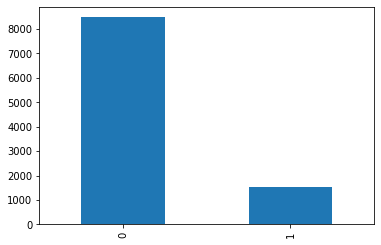

In [165]:
# Percent counts of Y
Y.value_counts().plot(kind='bar')

In [166]:
# transform zip to categorical

X['zip']= X['zip'].astype('str')

## Variable selection

### Continuous variables

In [167]:
# Cont cols (normalize for KNN)

# Continuous cols (normalize-for KNN)
cols_cont = ['Population', 'Children', 'Lat', 'Lng', 'Income', 'Age', 'Initial_Days', 'TotalCharge'] #leave out monthlycharge
X_cont = X[cols_cont]
X_cont.head(3)

,Population,Children,Lat,Lng,Income,Age,Initial_Days,TotalCharge
0,1455,0,41.87788,-91.83177,162756.62,78,10.585770,3726.702860
1,172,0,37.55125,-93.86187,45360.09,71,15.129562,4193.190458
2,18975,0,42.50667,-83.34946,43906.78,45,4.772177,2434.234222


### Categorical variables

In [168]:
# Cat cols-full list

cols_cat_all = X.loc[:, X.dtypes == np.object].columns.values.tolist() #have to translate back to list format
cols_cat_all = cols_cat_all[3:] #remove the first three cols, related to cust ID


In [169]:
# Cat cols-only those with limited tot unique value (otherwise too many categories created for dummies)

t = X[cols_cat_all].nunique().sort_values(ascending=False)
t = t.loc[lambda t: t < 20]  # change value to what is desired here, from 20
cols_cat_all_red = t.index.values.tolist()
X[cols_cat_all_red].nunique().to_frame('tot unique') #updated reduced list 


,tot unique
Education,12
Marital,5
Employment,5
Services,4
Complication_Risk,3
Gender,3
Area,3
Initial_Admin,3
Stroke,2
HighBlood,2


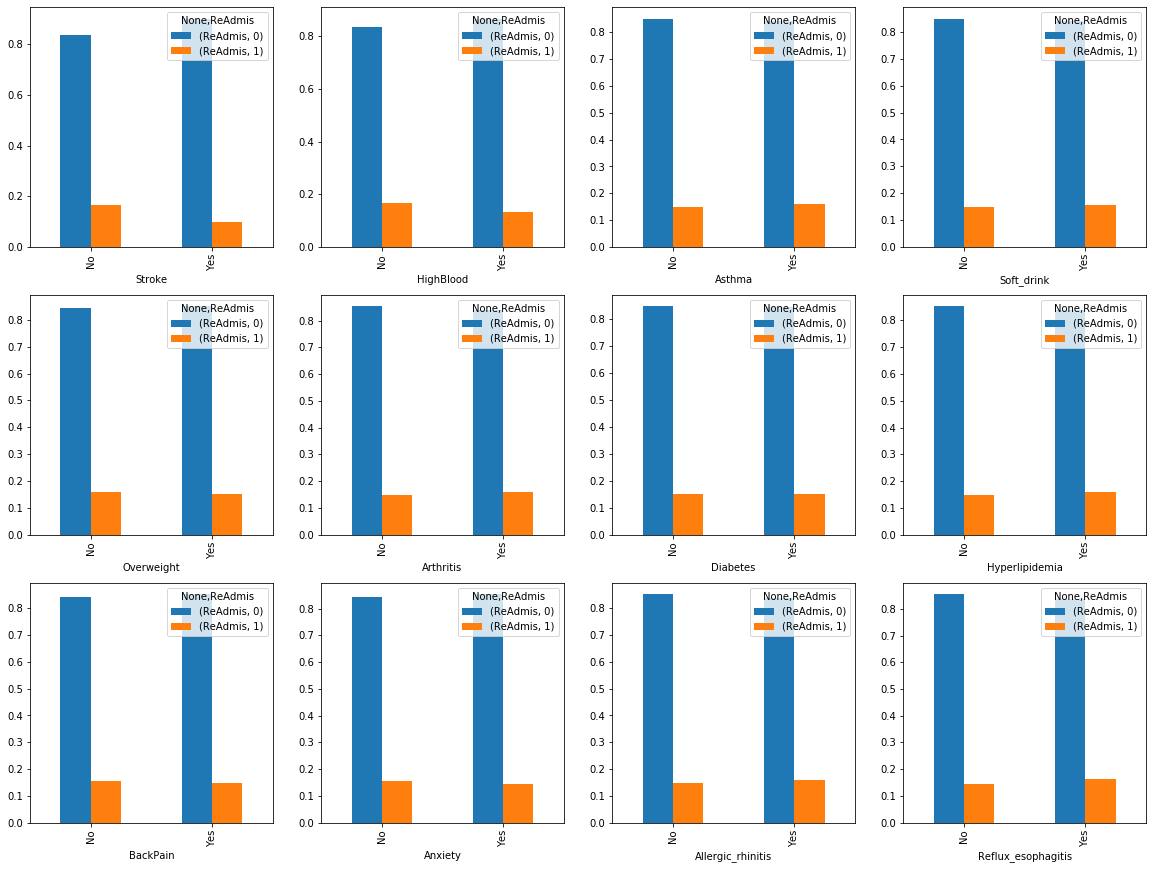

In [215]:
# Plot Readmit by Condition by each condition

# setup the dataframe of variables to plot
t = pd.concat([X[cols_cat_all_red[8:]], Y.rename('ReAdmis')], axis=1)

fig, ax = plt.subplots(3, 4, figsize=(20, 15))
for var, subplot in zip(t.columns[:-1], ax.flatten()):
    # count
    #t.groupby([var, 'ReAdmis']).size().unstack(fill_value=0).plot(kind='bar', ax=subplot)
    
    # percentile
    t1 = t.groupby([var, 'ReAdmis']).agg({'ReAdmis': 'count'})
    t1.groupby(level=0).apply(lambda x: x / float(x.sum())).unstack(fill_value=0).plot(kind='bar', ax=subplot)

In [171]:
# 1. Create dummies-for categorical cols (use reduced col list)

X_cat = pd.get_dummies(X[cols_cat_all_red], drop_first=True) # drop first as it is redundant
print('number of cat cols chosen: ', X[cols_cat_all_red].shape[1])
print('total cat cols after one hot encoding: ', X_cat.shape[1])
X_cat.head(3)

number of cat cols chosen:  20
total cat cols after one hot encoding:  42


,Education_Associate's Degree,Education_Bachelor's Degree,Education_Doctorate Degree,Education_GED or Alternative Credential,Education_Master's Degree,Education_No Schooling Completed,Education_Nursery School to 8th Grade,Education_Professional School Degree,Education_Regular High School Diploma,"Education_Some College, 1 or More Years, No Degree","Education_Some College, Less than 1 Year",Marital_Married,Marital_Never Married,Marital_Separated,Marital_Widowed,Employment_Part Time,Employment_Retired,Employment_Student,Employment_Unemployed,Services_CT Scan,Services_Intravenous,Services_MRI,Complication_Risk_Low,Complication_Risk_Medium,Gender_Male,Gender_Prefer not to answer,Area_Suburban,Area_Urban,Initial_Admin_Emergency Admission,Initial_Admin_Observation Admission,Stroke_Yes,HighBlood_Yes,Asthma_Yes,Soft_drink_Yes,Overweight_Yes,Arthritis_Yes,Diabetes_Yes,Hyperlipidemia_Yes,BackPain_Yes,Anxiety_Yes,Allergic_rhinitis_Yes,Reflux_esophagitis_Yes
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,1,1,0,0,1,1,0,1,1,1,0
1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0


In [172]:
# 2. For Naive Bayes, choose all cat columns and label encode 

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

X_cat_nb = X[cols_cat_all].apply(le.fit_transform)
print('number of cat cols in NB: ', X[cols_cat_all].shape[1])
print('total cat cols in NB after one hot encoding: ', X_cat_nb.shape[1])
X_cat_nb.head(3) 

number of cat cols in NB:  26
total cat cols in NB after one hot encoding:  26


,zip,City,State,County,Area,Timezone,Job,Education,Employment,Marital,Gender,Soft_drink,Initial_Admin,HighBlood,Stroke,Complication_Risk,Overweight,Arthritis,Diabetes,Hyperlipidemia,BackPain,Anxiety,Allergic_rhinitis,Reflux_esophagitis,Asthma,Services
0,4193,5661,12,125,1,3,321,0,0,1,1,0,1,1,0,2,0,1,1,0,1,1,1,0,1,0
1,5696,162,24,370,1,3,629,10,3,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,2
2,3737,1776,22,1025,0,5,571,0,0,3,0,0,0,1,0,2,1,0,1,0,0,0,0,0,0,0


In [173]:
# Join Cat and Noncat together

X_all = pd.concat([X_cont, X_cat],axis=1)
X_all_nb = pd.concat([X_cont, X_cat_nb],axis=1)

print('total cols for final df: ', X_all.shape[1]) 
print('total cols for final df, Naive Bayes: ',X_all_nb.shape[1])
X_all_nb.head()

total cols for final df:  50
total cols for final df, Naive Bayes:  34


,Population,Children,Lat,Lng,Income,Age,Initial_Days,TotalCharge,zip,City,State,County,Area,Timezone,Job,Education,Employment,Marital,Gender,Soft_drink,Initial_Admin,HighBlood,Stroke,Complication_Risk,Overweight,Arthritis,Diabetes,Hyperlipidemia,BackPain,Anxiety,Allergic_rhinitis,Reflux_esophagitis,Asthma,Services
0,1455,0,41.87788,-91.83177,162756.62,78,10.585770,3726.702860,4193,5661,12,125,1,3,321,0,0,1,1,0,1,1,0,2,0,1,1,0,1,1,1,0,1,0
1,172,0,37.55125,-93.86187,45360.09,71,15.129562,4193.190458,5696,162,24,370,1,3,629,10,3,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,2
2,18975,0,42.50667,-83.34946,43906.78,45,4.772177,2434.234222,3737,1776,22,1025,0,5,571,0,0,3,0,0,0,1,0,2,1,0,1,0,0,0,0,0,0,0
3,4139,1,40.56812,-74.24811,23220.36,84,1.714879,2127.830423,6147,4370,31,921,2,19,101,10,1,1,1,0,0,0,1,2,0,1,0,0,0,0,0,1,1,0
4,5107,0,40.88948,-99.95734,49982.55,70,1.254807,2113.073274,6056,1233,29,387,2,3,289,2,0,4,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1


# Train/Test Split Data

In [174]:
# Split the data into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_all, Y,
    test_size=0.3,
    random_state=1
)

# for Naive Bayes
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(
    X_all_nb, Y,
    test_size=0.3,
    random_state=1
)

In [175]:
# Print dimensions

print('Train cols: ', X_train.shape[1])
print('Test cols: ', X_test.shape[1])
print('Train cols, NB: ', X_train_nb.shape[1])
print('Test cols, NB: ', X_test_nb.shape[1])

Train cols:  50
Test cols:  50
Train cols, NB:  34
Test cols, NB:  34


# Predictive Modeling Techniques

# 1. KNN

This section covers KNN

In [138]:
# Load the K-Nearest Neighbors class
from sklearn.neighbors import KNeighborsClassifier

# Load the metrics libraries (used for all methods)
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix, classification_report

In [176]:
# Scale the data for cols_cont 

from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler() #MinMaxScaler()

X_train_std = X_train.copy() #copy train features df for KNN
X_test_std = X_test.copy()  #copy test features df for KNN
#transform cont cols only
X_train_std[cols_cont] = scaler.fit_transform(X_train_std[cols_cont]) 
X_test_std[cols_cont] = scaler.transform(X_test_std[cols_cont])

X_train_std.head(3)

,Population,Children,Lat,Lng,Income,Age,Initial_Days,TotalCharge,Education_Associate's Degree,Education_Bachelor's Degree,Education_Doctorate Degree,Education_GED or Alternative Credential,Education_Master's Degree,Education_No Schooling Completed,Education_Nursery School to 8th Grade,Education_Professional School Degree,Education_Regular High School Diploma,"Education_Some College, 1 or More Years, No Degree","Education_Some College, Less than 1 Year",Marital_Married,Marital_Never Married,Marital_Separated,Marital_Widowed,Employment_Part Time,Employment_Retired,Employment_Student,Employment_Unemployed,Services_CT Scan,Services_Intravenous,Services_MRI,Complication_Risk_Low,Complication_Risk_Medium,Gender_Male,Gender_Prefer not to answer,Area_Suburban,Area_Urban,Initial_Admin_Emergency Admission,Initial_Admin_Observation Admission,Stroke_Yes,HighBlood_Yes,Asthma_Yes,Soft_drink_Yes,Overweight_Yes,Arthritis_Yes,Diabetes_Yes,Hyperlipidemia_Yes,BackPain_Yes,Anxiety_Yes,Allergic_rhinitis_Yes,Reflux_esophagitis_Yes
2228,-0.563241,1.337954,-0.074290,-1.899559,0.021208,-0.805184,-1.010361,-0.863708,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1,0,1,0,0,1,1,0,1
5910,-0.659058,-0.046205,0.427207,-0.184808,-0.338085,-1.676348,1.123644,0.927807,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,0,1,0
1950,2.063916,0.876568,-1.595366,0.379655,1.892504,0.017582,-0.911589,-0.856243,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,1,1,1,0,0,0,1,1,0


In [177]:
# Train a K-Nearest Neighbors model

knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train_std, y_train) #Note: only X_train is std (not y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

In [178]:
# Print overall test-set accuracy, precision, recall, auc
y_pred = knn.predict(X_test_std)
y_prob = knn.predict_proba(X_test_std)[:, 1]

acc = accuracy_score(y_test, y_pred)*100
precision = precision_score(y_test, y_pred)*100
recall = recall_score(y_test, y_pred)*100
print('total accuracy = {:.1f}%'.format(acc))
print('total precision = {:.1f}%'.format(precision))
print('total recall = {:.1f}%'.format(recall))

auc = roc_auc_score(y_test, y_prob)
print('auc = {:.2f}%'.format(auc))
#confusion_matrix(y_test, y_pred)


total accuracy = 85.2%
total precision = 52.7%
total recall = 17.0%
auc = 0.84%


# 2. Naive Bayes

This section covers Naive Bayes

In [179]:
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
model = GaussianNB()

# Train the model using the training sets
nb = model.fit(X_train_nb,y_train_nb)

In [180]:
# Print overall test-set accuracy, precision, recall, auc
y_pred = nb.predict(X_test_nb)
y_prob = nb.predict_proba(X_test_nb)[:, 1]

acc = accuracy_score(y_test_nb, y_pred)*100
precision = precision_score(y_test_nb, y_pred)*100
recall = recall_score(y_test_nb, y_pred)*100
print('total accuracy = {:.1f}%'.format(acc))
print('total precision = {:.1f}%'.format(precision))
print('total recall = {:.1f}%'.format(recall))

auc = roc_auc_score(y_test_nb, y_prob)
print('auc = {:.2f}%'.format(auc))
#confusion_matrix(y_test, y_pred)

total accuracy = 84.3%
total precision = 49.1%
total recall = 98.2%
auc = 0.95%


# 3. Decision Tree

This section covers Decision Trees

In [144]:
from sklearn.tree import DecisionTreeClassifier

In [181]:
# Train a Random Forest

tree = DecisionTreeClassifier(max_depth=5)

tree.fit(X_train, y_train) 

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [182]:
# Print overall test-set accuracy, precision, recall, auc
y_pred = tree.predict(X_test)
y_prob = tree.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)*100
precision = precision_score(y_test, y_pred)*100
recall = recall_score(y_test, y_pred)*100
print('total accuracy = {:.1f}%'.format(acc))
print('total precision = {:.1f}%'.format(precision))
print('total recall = {:.1f}%'.format(recall))

auc = roc_auc_score(y_test, y_prob)
print('auc = {:.2f}%'.format(auc))
#confusion_matrix(y_test, y_pred)

total accuracy = 90.9%
total precision = 72.6%
total recall = 63.8%
auc = 0.95%


# 4. Random Forest 

This section covers Random Forest

In [147]:
from sklearn.ensemble import RandomForestClassifier

In [183]:
# Train a Random Forest

forest = RandomForestClassifier(
    n_estimators=100,
    max_features=15,
    max_depth=5,
    random_state=1,
)
forest.fit(X_train, y_train) 


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=15,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [184]:
# Print overall test-set accuracy, precision, recall, auc
y_pred = forest.predict(X_test)
y_prob = forest.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)*100
precision = precision_score(y_test, y_pred)*100
recall = recall_score(y_test, y_pred)*100
print('total accuracy = {:.1f}%'.format(acc))
print('total precision = {:.1f}%'.format(precision))
print('total recall = {:.1f}%'.format(recall))

auc = roc_auc_score(y_test, y_prob)
print('auc = {:.2f}%'.format(auc))
#confusion_matrix(y_test, y_pred)

total accuracy = 91.5%
total precision = 74.1%
total recall = 67.1%
auc = 0.96%


## Feature Importance for Random Forest

In [185]:
feature_imp = pd.Series(forest.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp[:10]

TotalCharge                          0.486809
Initial_Days                         0.407979
Complication_Risk_Medium             0.028330
Stroke_Yes                           0.013561
Initial_Admin_Emergency Admission    0.009557
Population                           0.006749
Income                               0.005942
Lat                                  0.005739
Lng                                  0.004620
Complication_Risk_Low                0.004522
dtype: float64

No handles with labels found to put in legend.


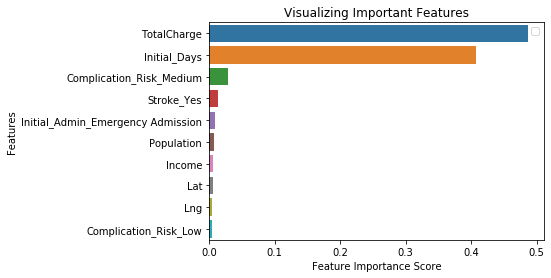

In [186]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp[:10], y=feature_imp[:10].index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

# 4. Gradient Boosting (not covered)
This section covers Gradient Boosting

In [152]:
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier

## AdaBoost

In [153]:
ada = AdaBoostClassifier(n_estimators=100)
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=None)

In [154]:
# Print overall test-set accuracy, precision, recall, auc
y_pred = ada.predict(X_test)
y_prob = ada.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)*100
precision = precision_score(y_test, y_pred)*100
recall = recall_score(y_test, y_pred)*100
print('total accuracy = {:.1f}%'.format(acc))
print('total precision = {:.1f}%'.format(precision))
print('total recall = {:.1f}%'.format(recall))

auc = roc_auc_score(y_test, y_prob)
print('auc = {:.2f}%'.format(auc))

total accuracy = 90.8%
total precision = 94.1%
total recall = 95.2%
auc = 0.96%


## Gradient boost

In [155]:
gb = GradientBoostingClassifier(n_estimators=100)
gb.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [156]:
# Print overall test-set accuracy, precision, recall, auc
y_pred = gb.predict(X_test)
y_prob = gb.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)*100
precision = precision_score(y_test, y_pred)*100
recall = recall_score(y_test, y_pred)*100
print('total accuracy = {:.1f}%'.format(acc))
print('total precision = {:.1f}%'.format(precision))
print('total recall = {:.1f}%'.format(recall))

auc = roc_auc_score(y_test, y_prob)
print('auc = {:.2f}%'.format(auc))

total accuracy = 91.7%
total precision = 94.6%
total recall = 95.6%
auc = 0.96%


In [157]:
gb = GradientBoostingClassifier(n_estimators=100,learning_rate=.02, max_features=15, max_depth=5, random_state=1)
gb.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.02, loss='deviance', max_depth=5,
                           max_features=15, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [158]:
# Print overall test-set accuracy, precision, recall, auc
y_pred = gb.predict(X_test)
y_prob = gb.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)*100
precision = precision_score(y_test, y_pred)*100
recall = recall_score(y_test, y_pred)*100
print('total accuracy = {:.1f}%'.format(acc))
print('total precision = {:.1f}%'.format(precision))
print('total recall = {:.1f}%'.format(recall))

auc = roc_auc_score(y_test, y_prob)
print('auc = {:.2f}%'.format(auc))

total accuracy = 91.6%
total precision = 93.8%
total recall = 96.5%
auc = 0.96%
